In [1]:
from load_modules import *
import copy


In [5]:
filenames = ["../../data/Raman_Mouse/noise_removed_used_for_tests/Kidney_map_150z25_60s_#35.txt"] 
# file_location = "../../data/Raman_Mouse/noise_removed_used_for_tests/"
# filenames = glob.glob(file_location+'/[!Wave|metadata]*.txt')
data = load_files([filenames], True)


start loading data, number of files 1
opening file 1 of 1: ../../data/Raman_Mouse/noise_removed_used_for_tests/Kidney_map_150z25_60s_#35.txt
loaded  file 1 of 1: ../../data/Raman_Mouse/noise_removed_used_for_tests/Kidney_map_150z25_60s_#35.txt


In [6]:
image_n = -1
raw_lst = data[0][image_n].reshape(-1,data[0][0].shape[-1])
x = data[1][0]

0.0% progress


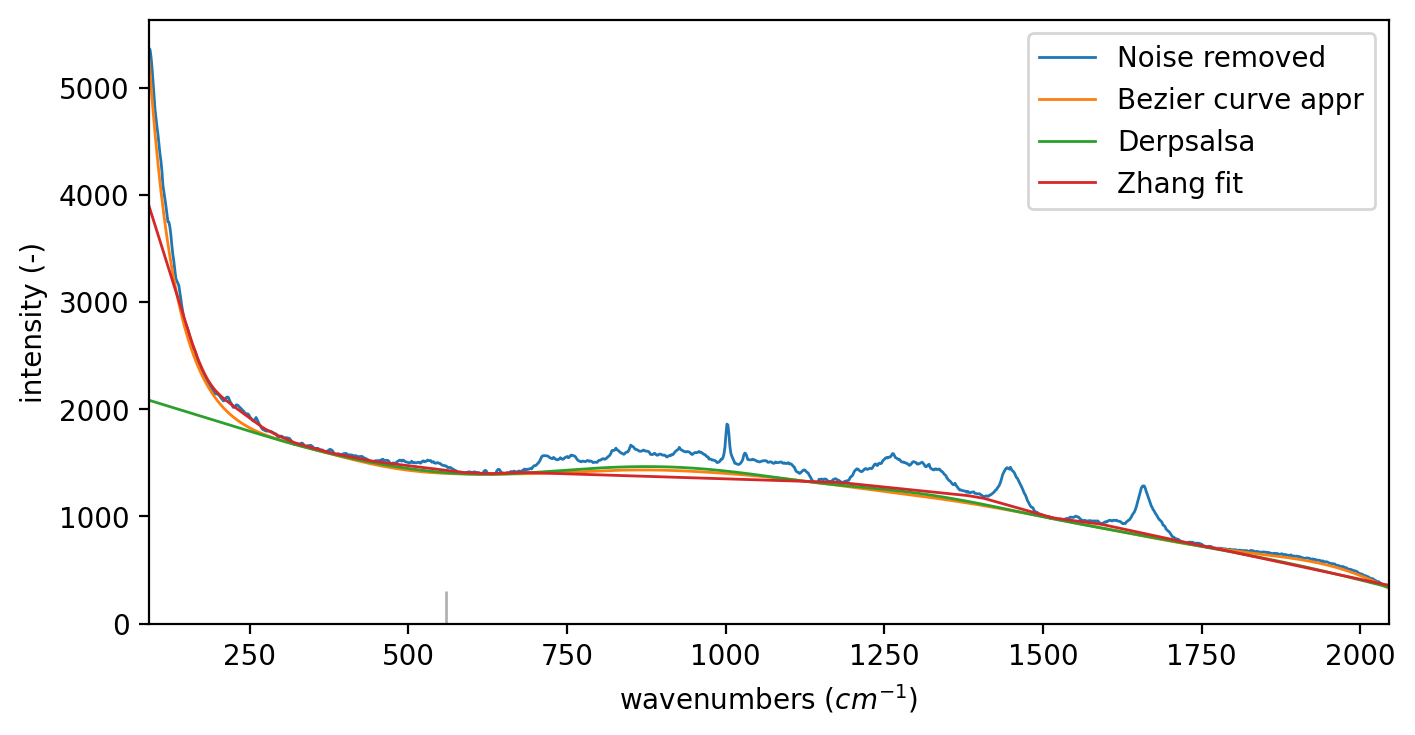

2.666666666666667% progress


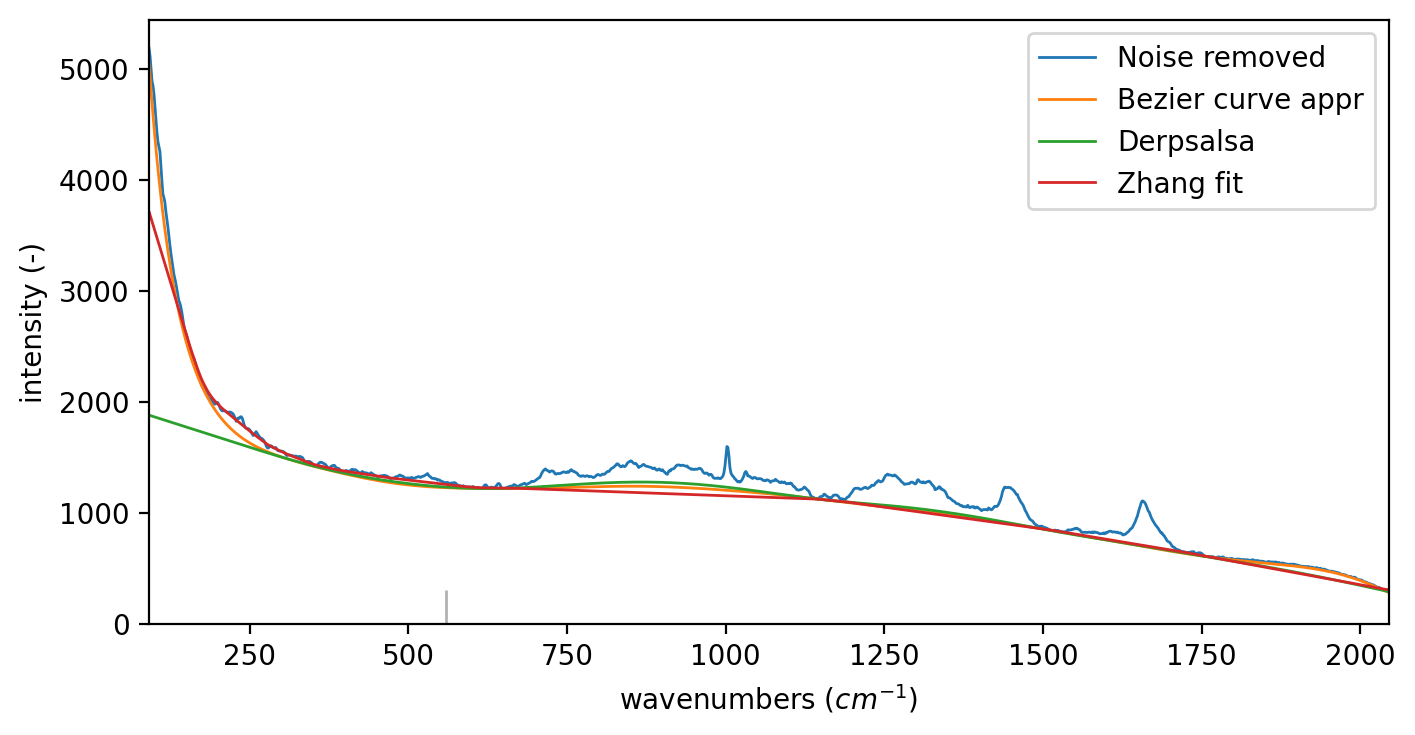

WARING max iteration reached!
5.333333333333334% progress


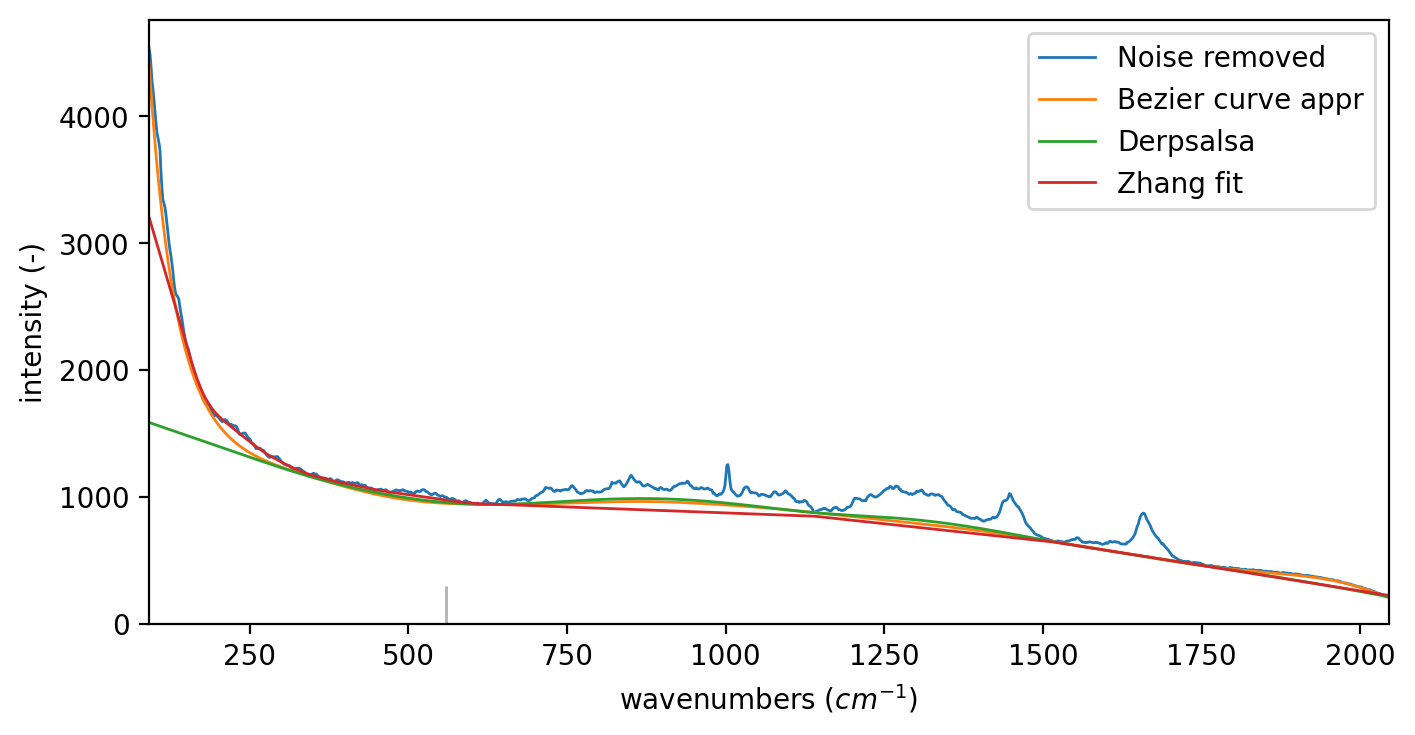

WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
8.0% progress


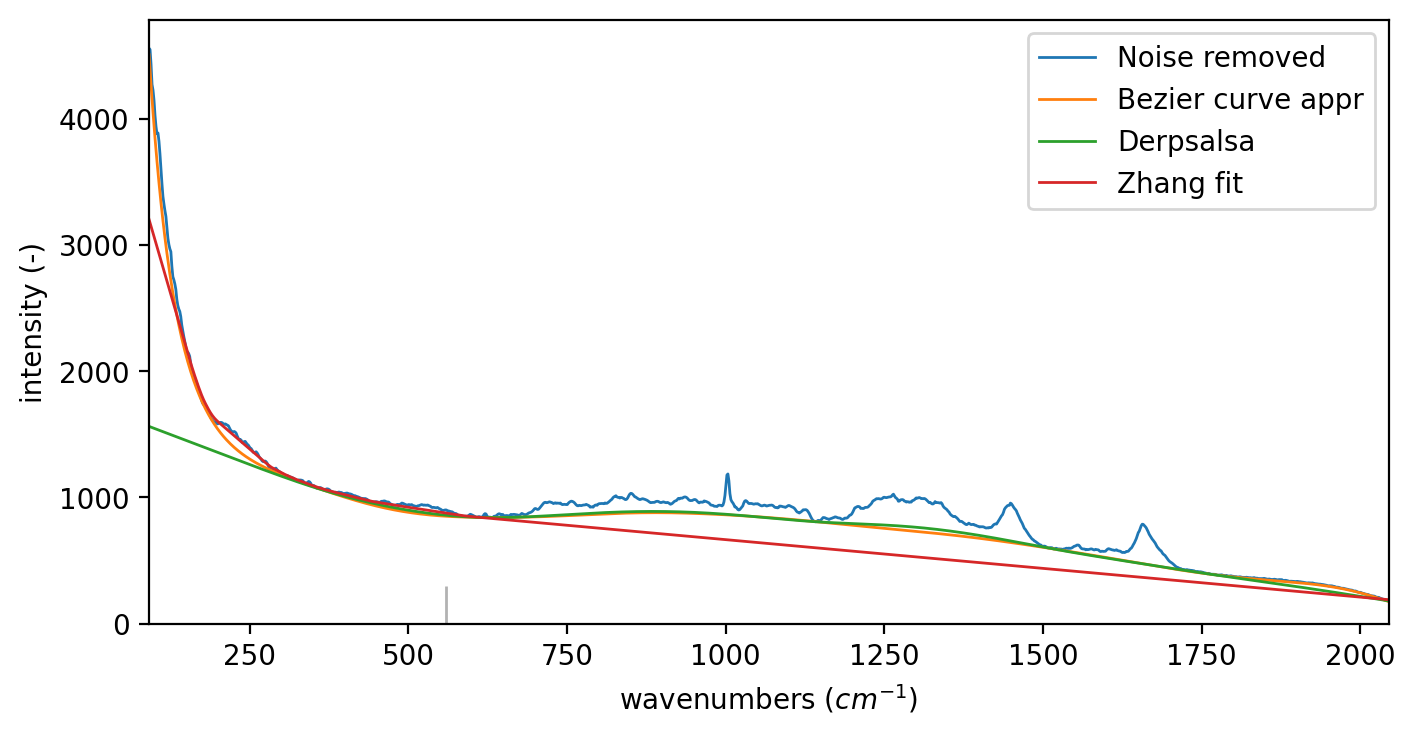

WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
10.666666666666668% progress


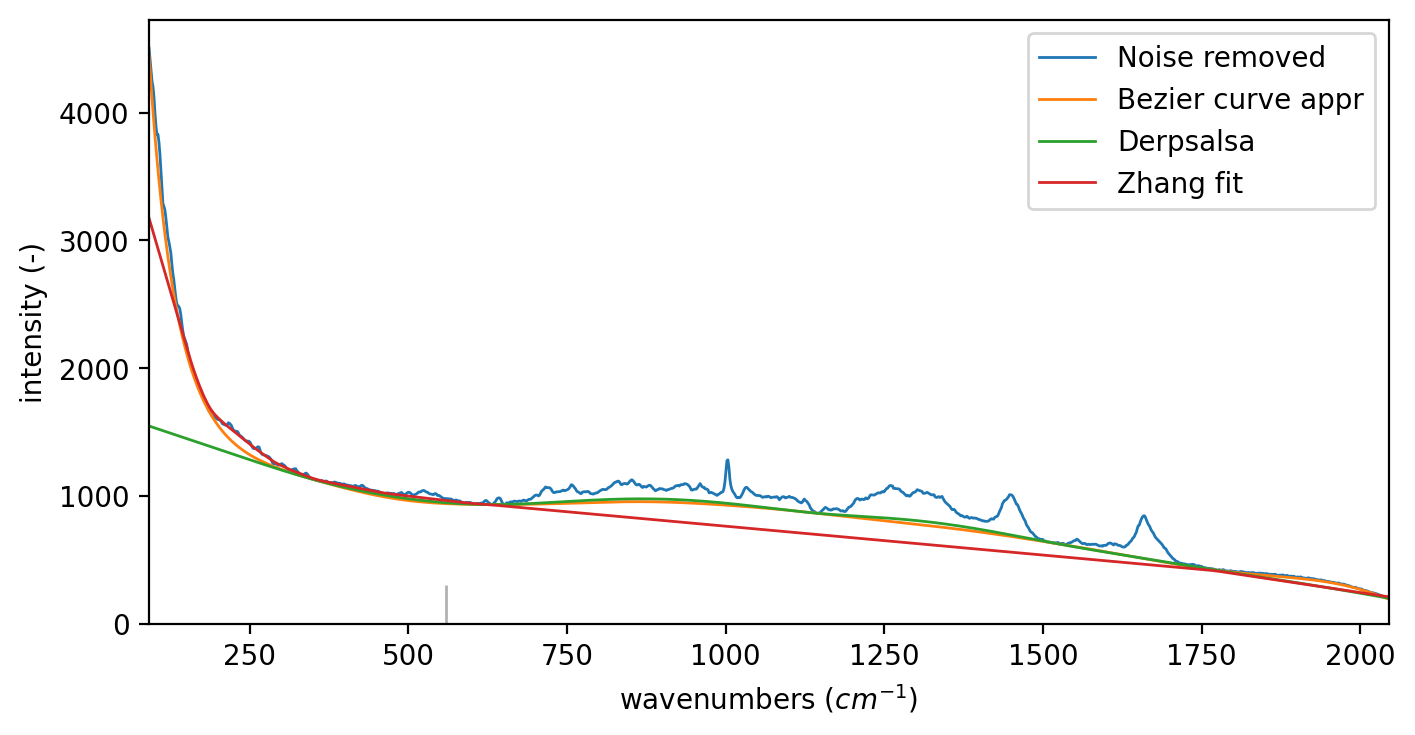

WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
13.333333333333334% progress


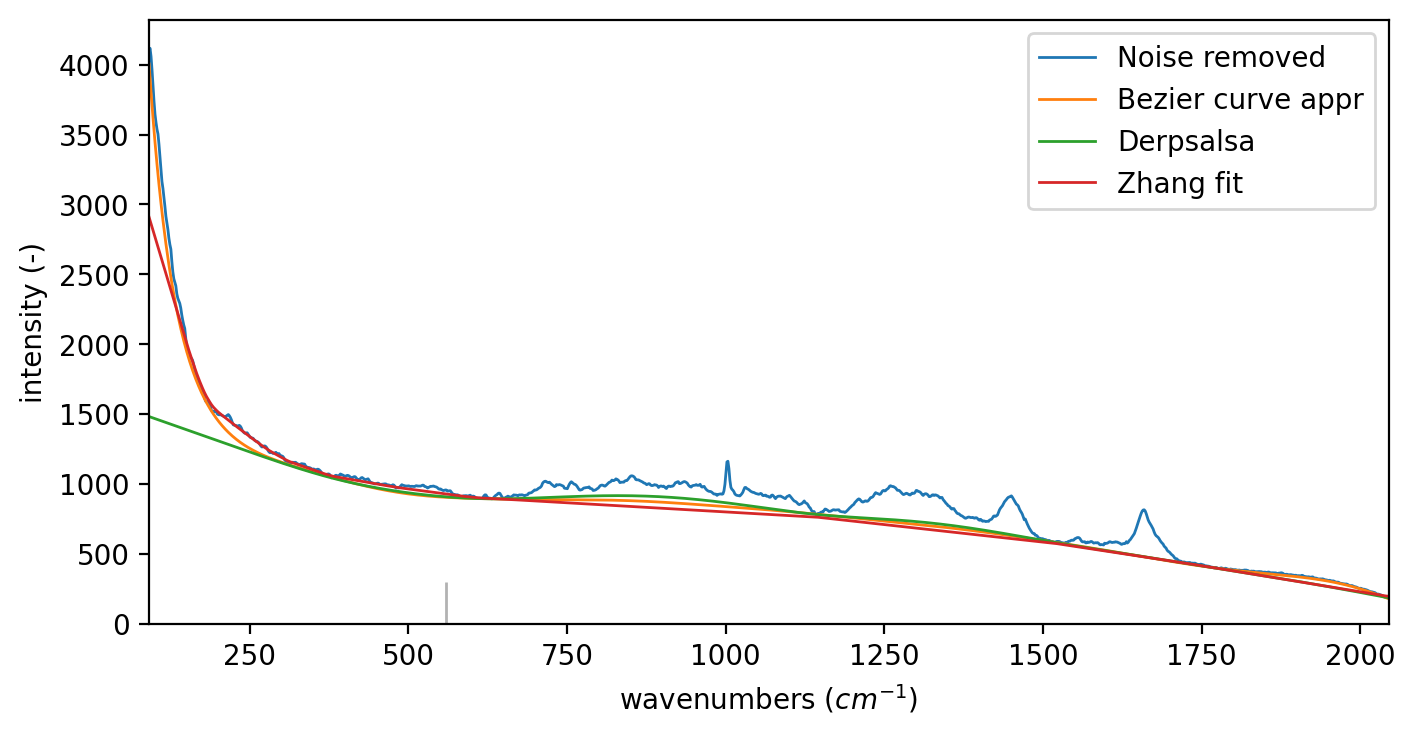

In [8]:
from BaselineRemoval import BaselineRemoval

plt.rcParams['figure.figsize'] = (8.0, 4.0)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['lines.linewidth'] = 1

split = splitting.split(x, size=x.shape[0], FWHM=400, segment_width=450, algorithm="Bezier curve")

proposed_error = []
ALS_error = []
zhang_error = []

LEFT = 300

def calc_error(raw, photo):
    return [error.MSE(raw, photo), error.MSGE(photo), error.MAPE(raw, photo)]

def calc_error_optimum(photo_org, photo):
    return [error.MSE(photo_org, photo), error.TMSGE(photo_org, photo), error.MAPE(photo_org, photo)]

for j, raw in enumerate(raw_lst):
    photo = split(raw.reshape(1,-1))[0]
    photo_ALS = derpsalsa.derpsalsa_baseline(x, raw, als_lambda=1e3, als_p_weight=1e-5, display=0)
    baseObj = BaselineRemoval(raw)
    photo_zhangfit = raw - baseObj.ZhangFit(lambda_=50, itermax=30)

    proposed_error.append(calc_error(raw, photo) + calc_error(raw[:LEFT], photo[:LEFT]) + calc_error(raw[LEFT:], photo[LEFT:]))
    ALS_error.append(calc_error(raw, photo_ALS) + calc_error(raw[:LEFT], photo_ALS[:LEFT]) + calc_error(raw[LEFT:], photo_ALS[LEFT:]))
    zhang_error.append(calc_error(raw, photo_zhangfit) + calc_error(raw[:LEFT], photo_zhangfit[:LEFT]) + calc_error(raw[LEFT:], photo_zhangfit[LEFT:]))

#     print("new", ("{:.3f} \t"*9).format(*proposed_error[-1]))
#     print("Zha", ("{:.3f} \t"*9).format(*zhang_error[-1]))
#     plt.plot(x, raw, label="Noise removed")
#     plt.plot(x, photo.reshape(-1), label="Bezier curve appr")
#     plt.plot(x, photo_ALS, label="Derpsalsa")
#     plt.plot(x, photo_zhangfit, label="Zhang fit")
#     plt.plot(x, photo_org, "--")
#     plt.vlines(x[LEFT], 0, 300, 'k', alpha=0.3)
#     plt.ylim(0)
#     plt.xlim(x[0], x[-1])
#     plt.xlabel(r"wavenumbers ($cm^{-1}$)")
#     plt.ylabel("intensity (-)")
#     plt.legend()
#     plt.show()
#     break
    
    if not j % 100:
        print(f"{j/len(raw_lst)*100}% progress")
        plt.plot(x, raw, label="Noise removed")
        plt.plot(x, photo.reshape(-1), label="Bezier curve appr")
        plt.plot(x, photo_ALS, label="Derpsalsa")
        plt.plot(x, photo_zhangfit, label="Zhang fit")
#         plt.plot(x, photo_org, "--")
        plt.vlines(x[LEFT], 0, 300, 'k', alpha=0.3)
        plt.ylim(0)
        plt.xlim(x[0], x[-1])
        plt.xlabel(r"wavenumbers ($cm^{-1}$)")
        plt.ylabel("intensity (-)")
        plt.legend()
    plt.show()
    if j > 500:
        break


In [9]:
error1 = np.array(copy.copy(proposed_error))
error2 = np.array(copy.copy(ALS_error))
error3 = np.array(copy.copy(zhang_error))

In [10]:
# print(f"{np.mean(error1, 0)},\t {np.std(error1, 0)}")
# print(f"{np.mean(error2, 0)},\t {np.std(error2, 0)}")
# print(f"{np.mean(error3, 0)},\t {np.std(error3, 0)}")

In [11]:
import matplotlib.patches as mpatches
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams['figure.dpi'] = 500
plt.rcParams['lines.linewidth'] = 1

error_lst = ["MSE","(T)MSGE", "MAPE"]

def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))
    violin['cmeans'].set_edgecolor('m')
    violin['cmeans'].set_linewidth(2)
    violin["cbars"].set_alpha(0)
    return violin

def change_box(box):
    for pc in box["medians"]:
        pc.set_color("r")
        pc.set_alpha(1)
            
    for line in ["whiskers", "boxes", "caps"]:
        for pc in box[line]:
            pc.set_linewidth(0.5)
    return box

def plot_results(error_n=0):
    global labels 
    labels = []

    add_label(plt.violinplot(error1[:,error_n::3], positions=[0,3,6],  showmeans=True), "new")  
    add_label(plt.violinplot(error2[:,error_n::3], positions=[1,4,7], showmeans=True), "ALS")
    violin = add_label(plt.violinplot(error3[:,error_n::3], positions=[2,5,8], showmeans=True), "Zhang")

    change_box(plt.boxplot(error1[:,error_n::3], positions=[0,3,6]))
    change_box(plt.boxplot(error2[:,error_n::3], positions=[1,4,7]))
    box = change_box(plt.boxplot(error3[:,error_n::3], positions=[2,5,8]))

    labels.append((violin["cmeans"], "mean"))
    labels.append((box["medians"][0], "median"))

    plt.legend(*zip(*labels))
    plt.xticks(ticks=range(1,9,3), labels=["total","left","right"])
    plt.ylabel(error_lst[error_n])
#     plt.yscale("log")
    plt.ylim(0, 3*np.max(error1[:,error_n::3]))
    plt.show()


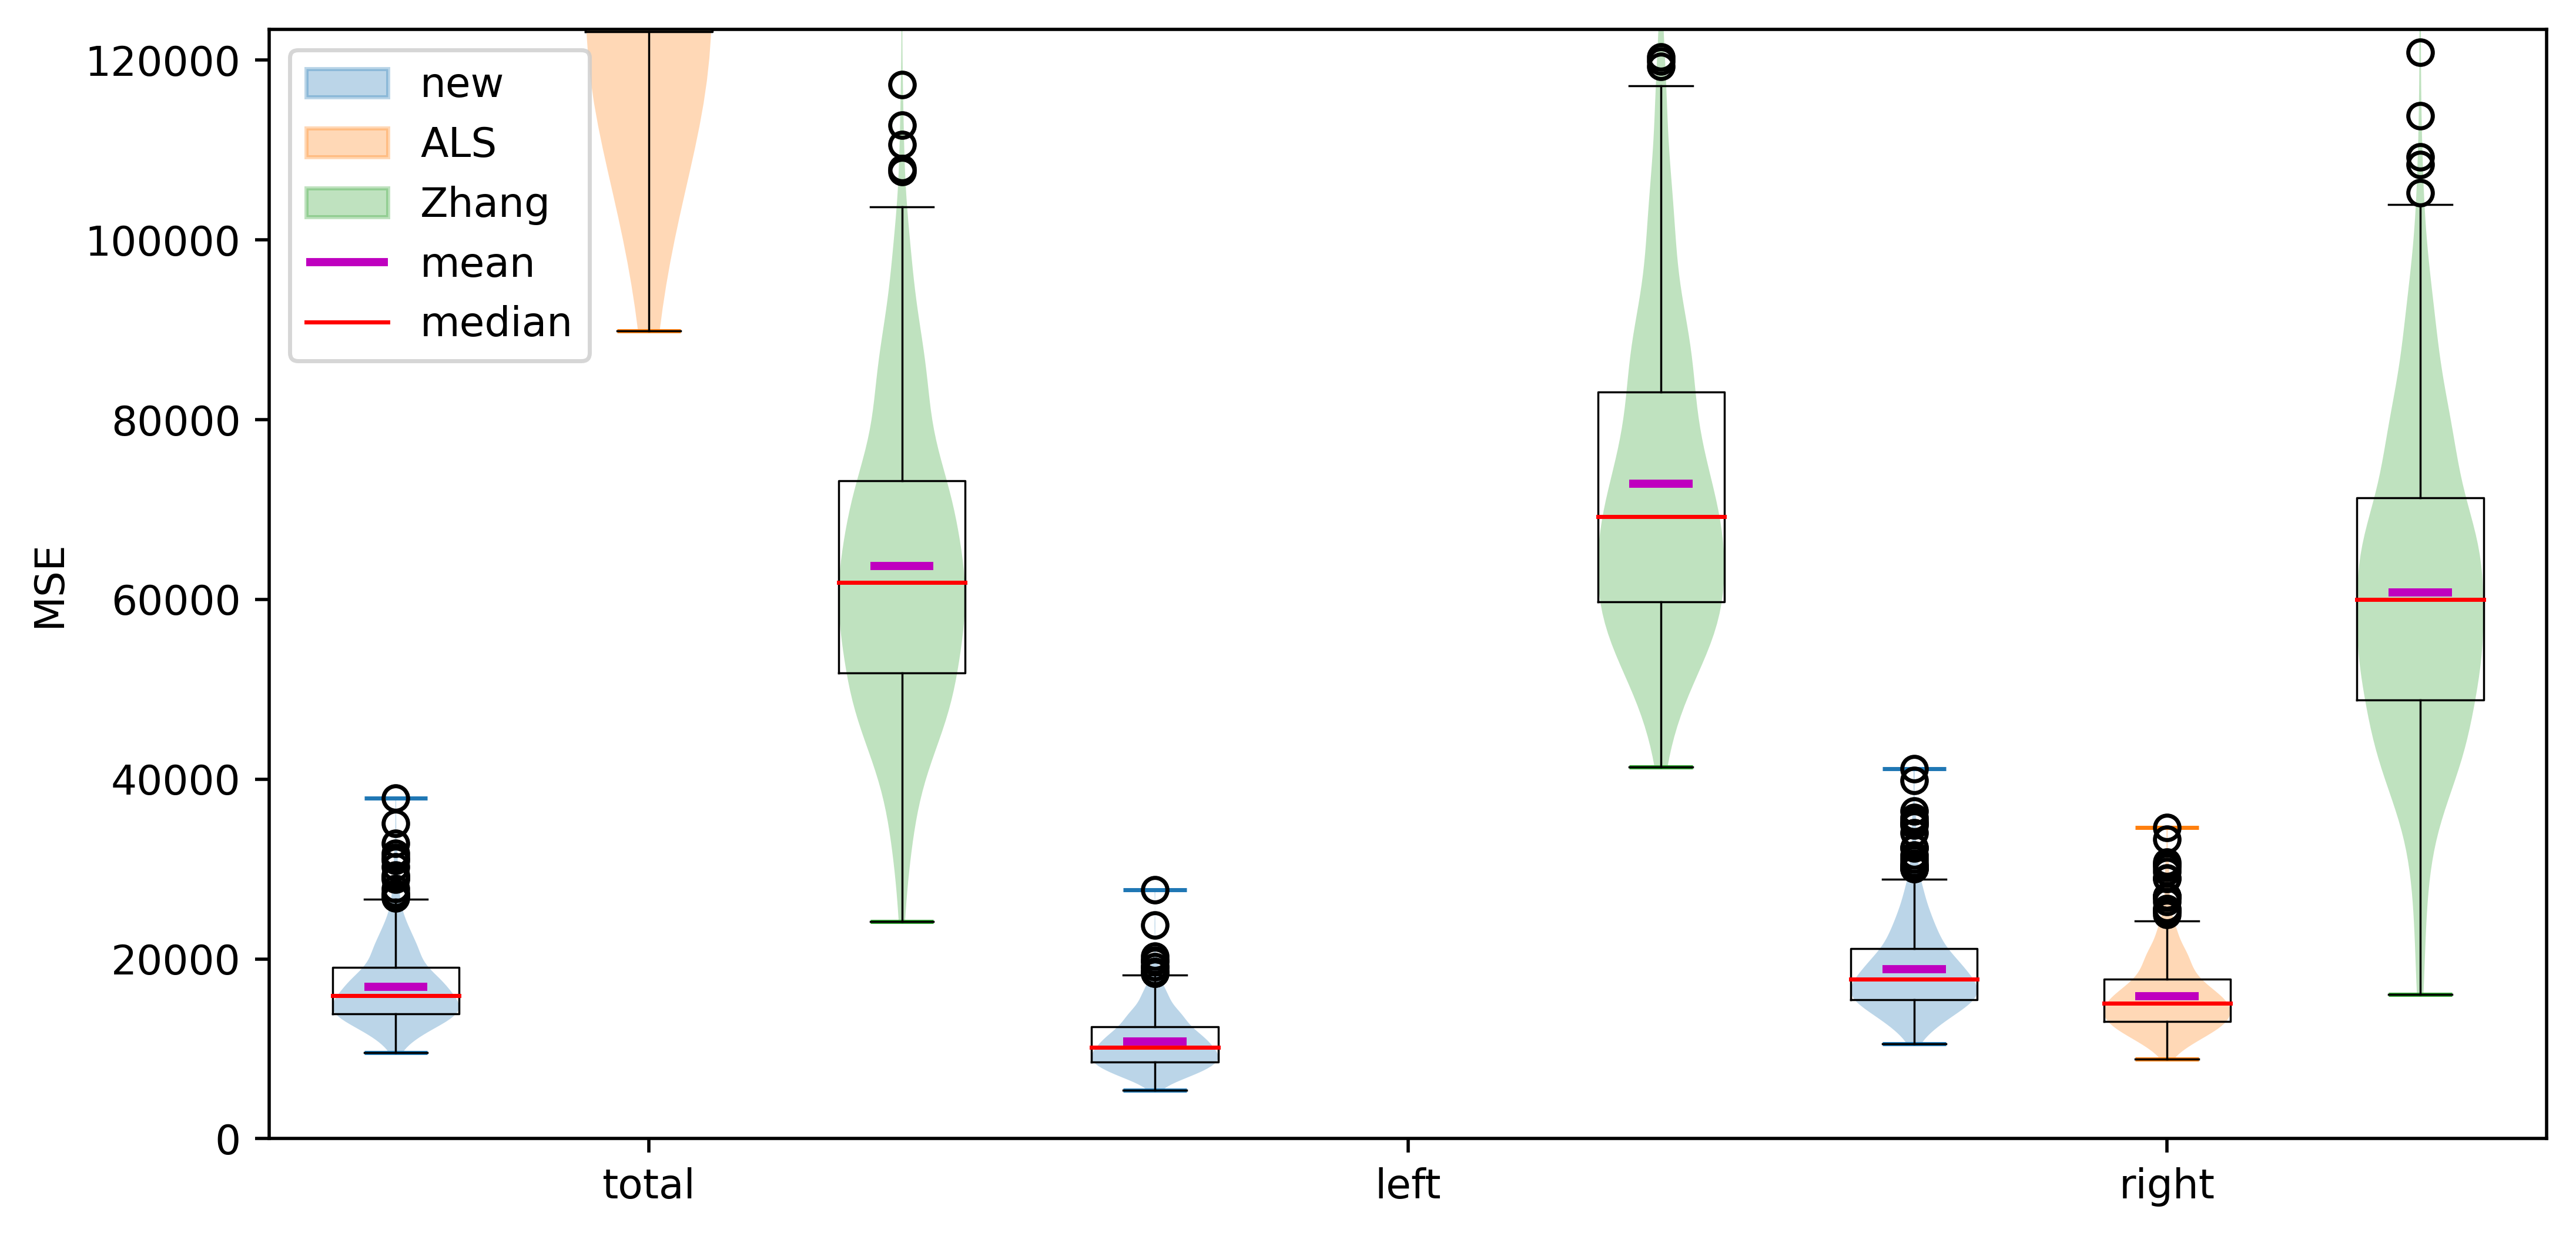

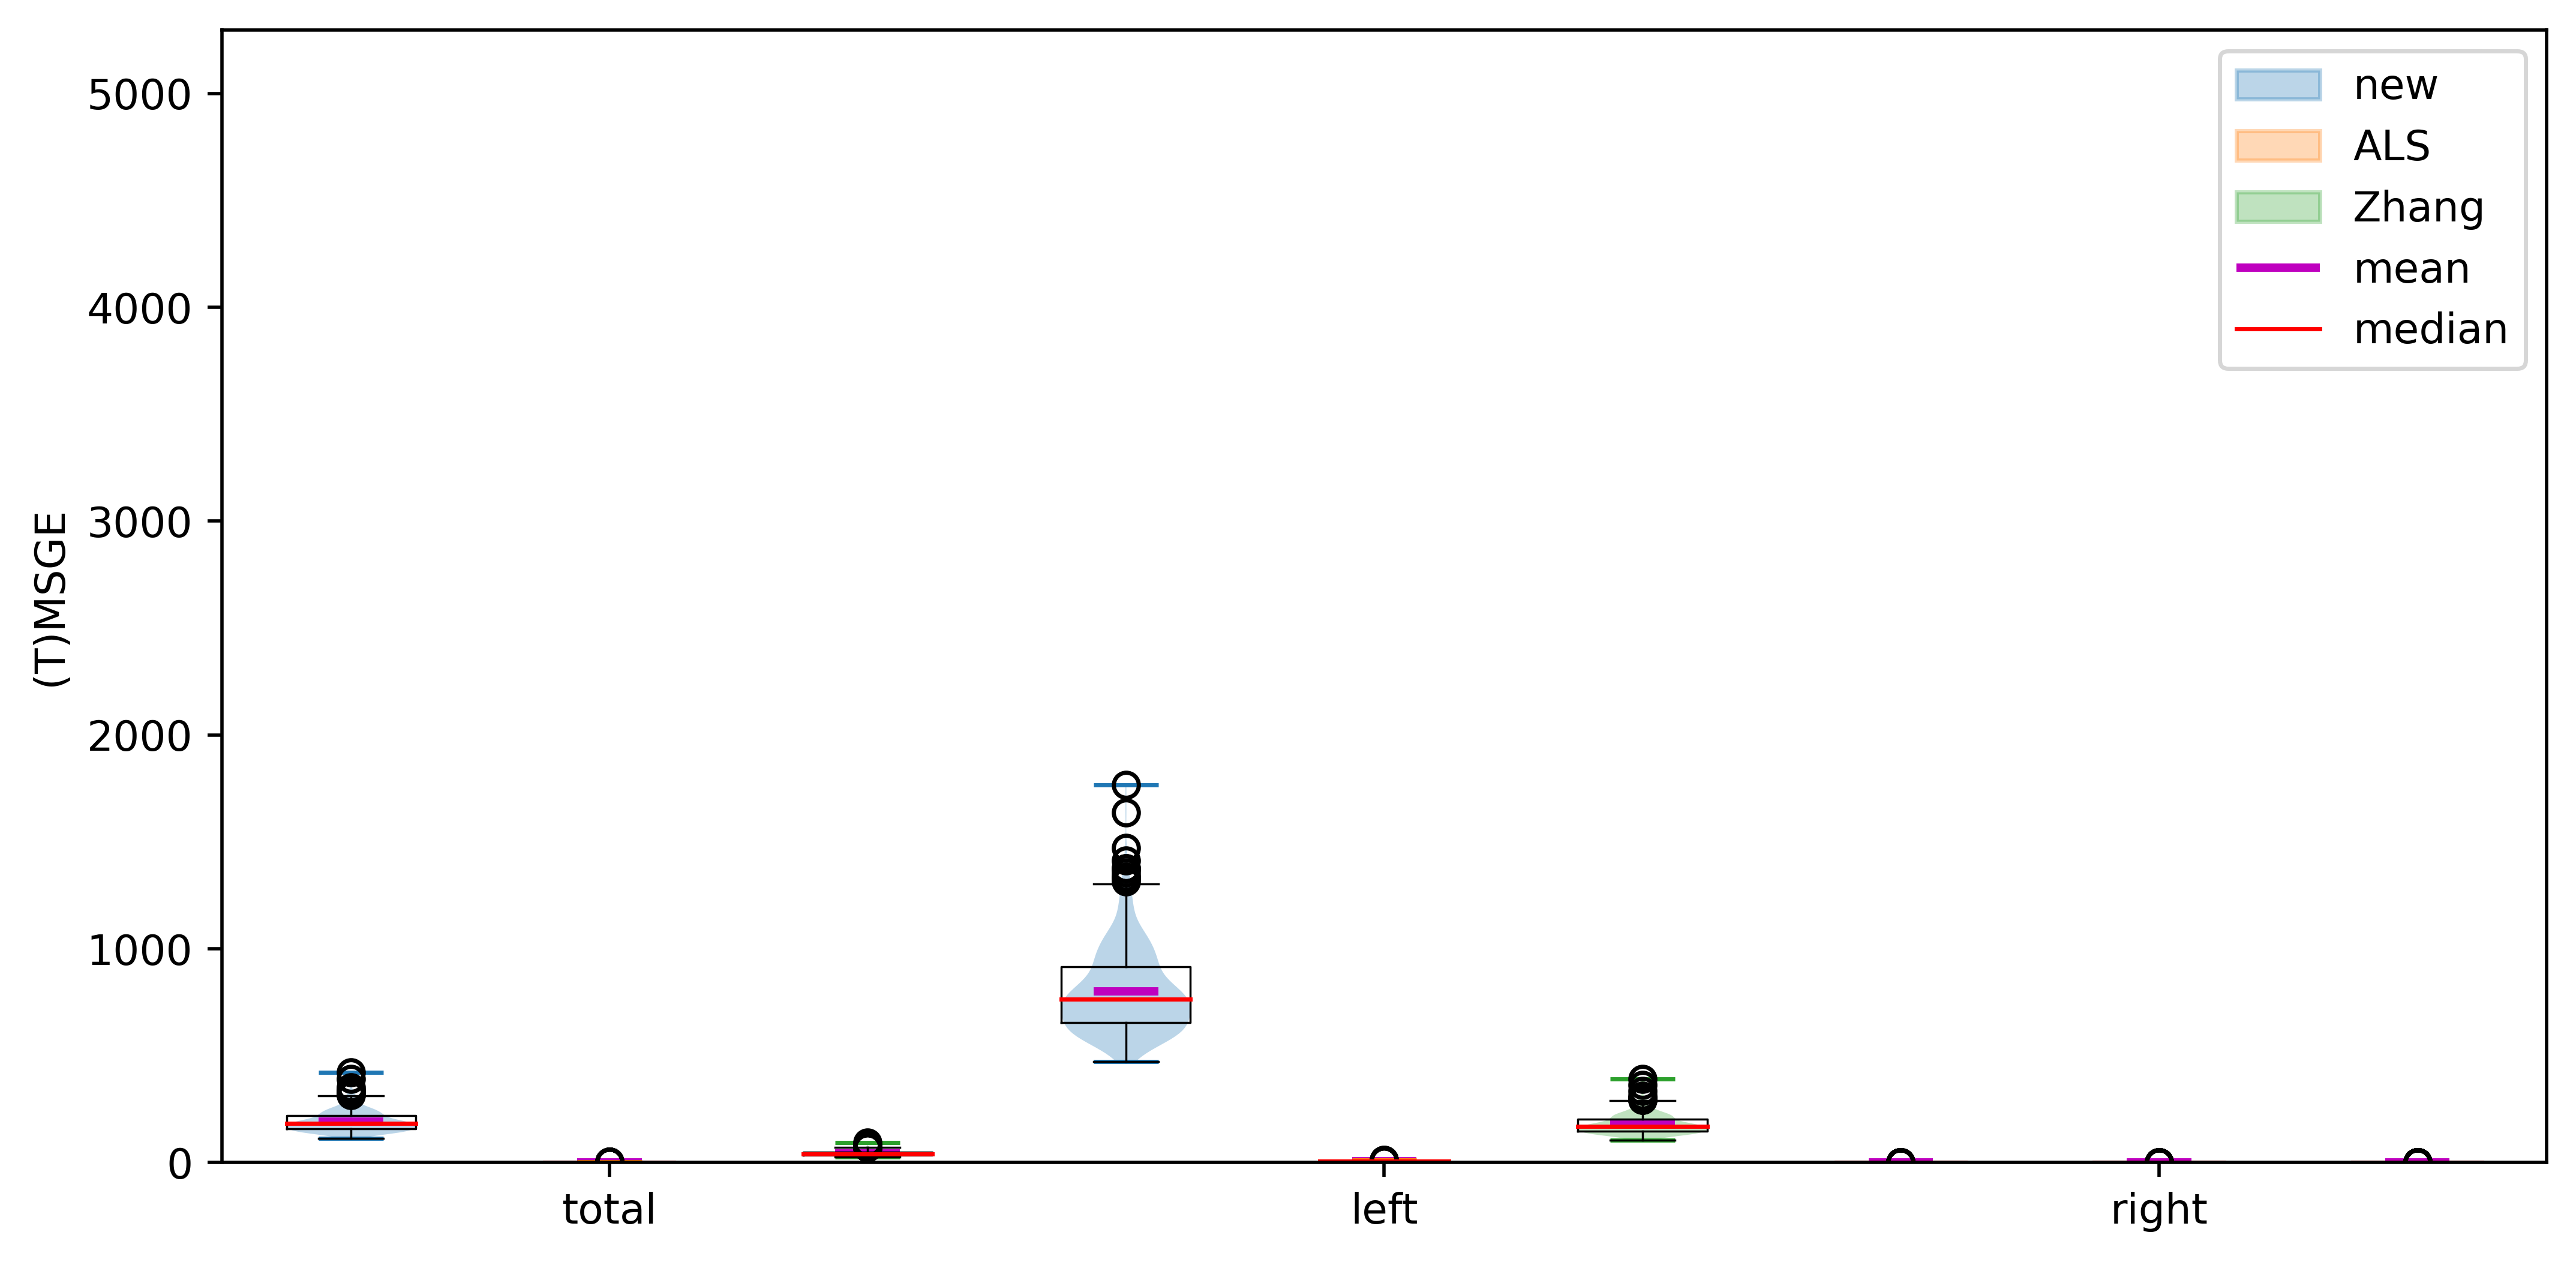

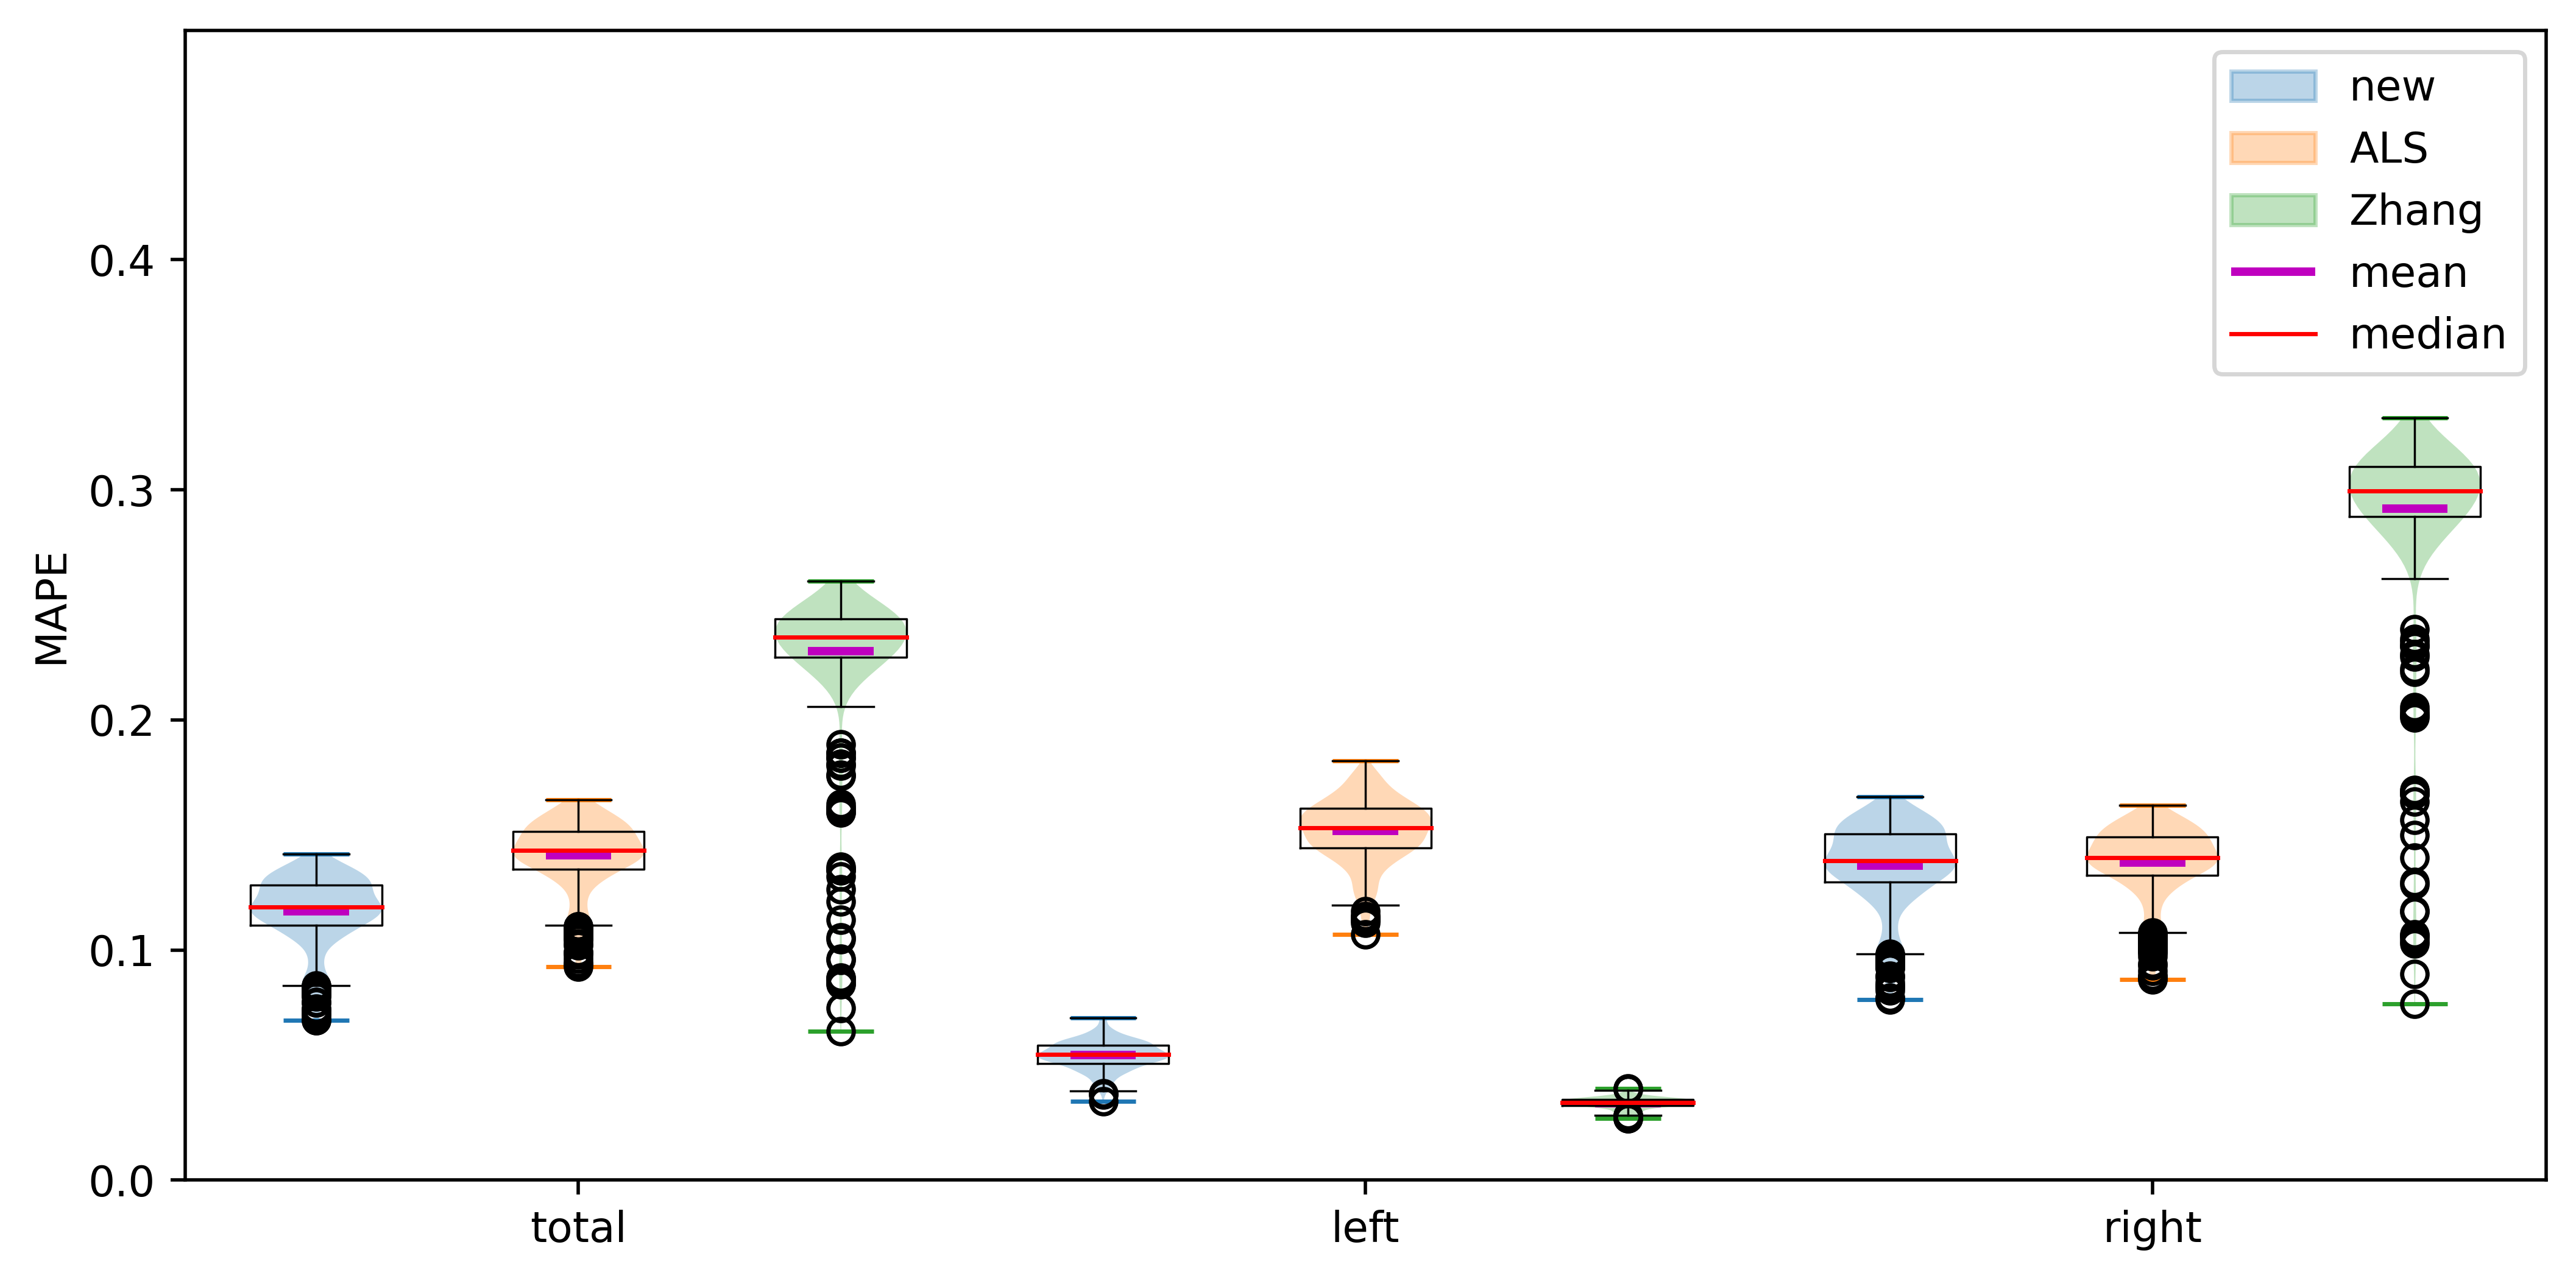

In [12]:
plot_results(0)
plot_results(1)
plot_results(2)